In [1]:
from os import path
import glob
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from astropy.table import Table
from IPython.display import Image

# Dimensionality reduction
### credit Jake Vanderplas, Adrian Price-Whelan

The goal of dimensionality reduction is to find a model independent way of compressing the information without losing too much information.

The Principal Component Analysis (PCA) uses a linear transformation that project the dataset onto the top few eigenvectors components of the covariance matrix that contain the largest variance.

Consider the following case of a 2-D Gaussian distribution:

Text(0, 0.5, '$x_2$')

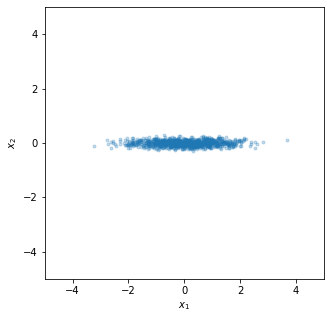

In [2]:
x = np.random.normal(0, 1., size=1024)
y = np.random.normal(0, 0.1, size=x.size)

plt.figure(figsize=(5,5))
plt.scatter(x, y, alpha=0.25, marker='.')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

If we are bound to reduce this 2-D Gaussian, we better choose preserve $x_1$ as it contains a larger share of the variance of the distribution.

If we flatten out the $x_2$ dimension.

Text(0, 0.5, '$x_2$')

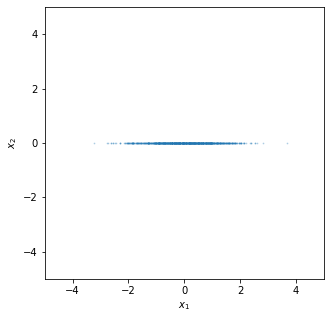

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(x, y*0., alpha=0.25, marker='.', s= 3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## Principal Component Analysis (PCA)

The "principal components" of a dataset are the eigenvectors of the covariance matrix ordered by the magnitude of the variance.  With the first component being that has the largest variance. 

PCA then projects the original data onto a subspace defined by a subset of the eigenvectors. 

The covariance matrix is N by N where N is the number of the dimension of the original dataset.

In [4]:
Image(url= "data/eigenvector.png")

In [5]:
X = np.loadtxt('data/correlated_data.csv', delimiter=',')
X.shape

(1024, 3)

### Let's look at a test case in 3-D

In [6]:
import plotly.graph_objs as go
trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',               # Set color to the z-values
        colorscale='Viridis',   # Choose a colorscale
        opacity=0.8
    )
)

# Define the layout of the plot
layout = go.Layout(
    scene=dict(
        xaxis_title='x1',
        yaxis_title='x2',
        zaxis_title='x3'
    ),
    title="Interactive 3D Scatter Plot"
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

fig.write_html("3-D_scatter.html")

### Now let's find the covariance matrix of this dataset and its eigenvector decomposition

In [7]:
Cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(Cov)

We sort by the eigenvalues and project the data onto the eigenbasis. The 0th feature is now the most informative, and so on.

In [8]:
idx = eig_vals.argsort()
Y = X[:,idx] @ eig_vecs[idx] # projection

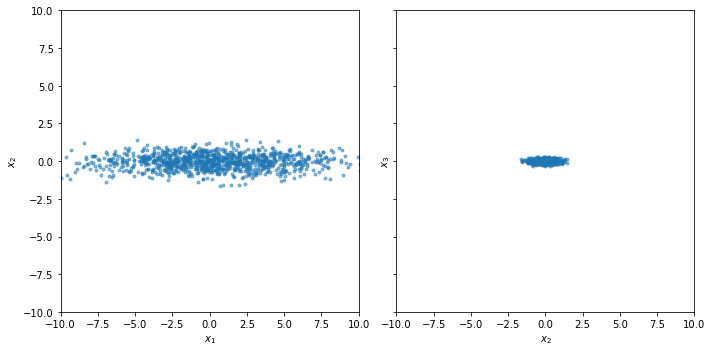

In [9]:
fig,axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

axes[0].plot(Y[:,0], Y[:,1], marker='.', alpha=0.5, linestyle='none')
axes[1].plot(Y[:,1], Y[:,2], marker='.', alpha=0.5, linestyle='none')

axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)

axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$x_3$')

fig.tight_layout()

One way to quantify how much variance or information is contained along each eigenvector is to compute the _cumulative explained variance_. This tells you, at a given eigenvector, what fraction the total variance is explained by the given eigenvector and all eigenvectors preceding it (with larger eigenvalues). Heres the CEV for the example above:

In [10]:
np.cumsum(eig_vals) / np.sum(eig_vals)

array([0.98409181, 0.99938294, 1.        ])

This tells us that the 0th eigenvector *alone* contains ~98% of the variance of the distribution, and 99.9% is contained with the first two. You have to decide what fraction of the explained variance is OK with you, and truncate the eigenvectors there. Here, if we arbitrarily say we want >95% of the explained variance, we would just keep the first eigenvector.

---

## Example: Eigenfaces

Here we're going to do an example of PCA with some more interesting, high-dimensional data: pictures of faces. Each image is 62 x 47, so if we treat each pixel as a feature, that's 2914 features *per image* or *per object*. We'll do a PCA on that large feature-space and see how many "eigenvectors" we need to explain 95% of the variance (i.e. do a pretty good job at representing faces).


In [11]:
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people

In [12]:
# fetch the face image data
faces = fetch_lfw_people(min_faces_per_person=32)

In [13]:
faces.images.shape, faces.data.shape

((2248, 62, 47), (2248, 2914))

Here's a sample of what some of the images look like:

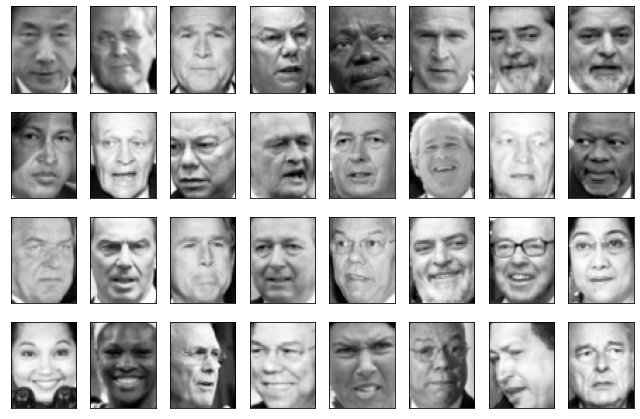

In [14]:
fig, axes = plt.subplots(4, 8, figsize=(9, 6),
                         subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i], cmap='Greys_r')
    
fig.tight_layout()

### Hopefully you also recognize some of these people.

We can also plot the pixel "flux" values as if the are features / dimensions of the data. Here are a few projections of the data:

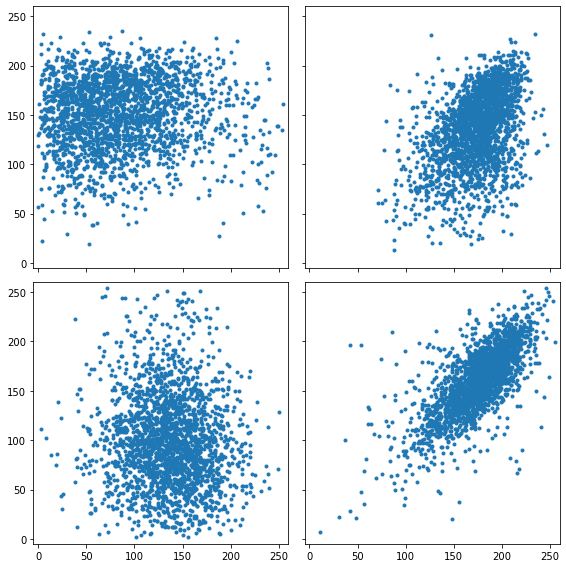

In [15]:
fig,axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

axes[0,0].scatter(faces.images[:,0,0], faces.images[:,32,16], marker='.')
axes[0,1].scatter(faces.images[:,11,21], faces.images[:,25,13], marker='.')
axes[1,0].scatter(faces.images[:,13,41], faces.images[:,59,12], marker='.')
axes[1,1].scatter(faces.images[:,2,20], faces.images[:,4,11], marker='.')

axes[0,0].set_xlim(-5, 260)
axes[0,0].set_ylim(-5, 260)

fig.tight_layout()

### as we can see, some pixels are definitely correlated with each other.

Let's now perform a PCA on the image data, and keep the largest 256 eigenvectors (remember each eigenvectors has the same dimension as the orignal dataset). Here, we'll use the PCA implementation in `scikit-learn`:

In [16]:
pca = PCA(256)
pca.fit(faces.data)

PCA(n_components=256)

Let's visualize the top eigenfaces:

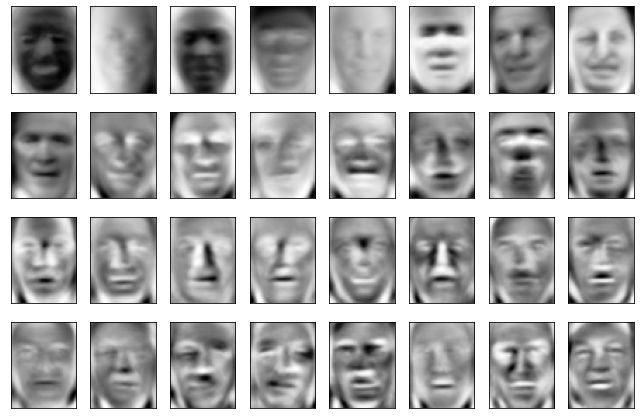

In [17]:
fig, axes = plt.subplots(4, 8, figsize=(9, 6),
                         subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='Greys_r')
    
fig.tight_layout()

Apart from being slightly terrifying, it's cool! You can see components needed for shading faces, making eyes darker, making noses wider, etc. Let's look at the cumulative explained variance:

/var/folders/x_/f1wlthp10gj0cj2f7fgh86wc0000gq/T/ipykernel_19297/2897932407.py:5: MatplotlibDeprecationWarning:

The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



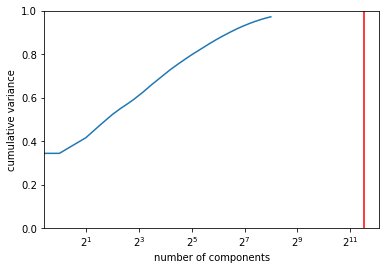

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='')
plt.xlabel('number of components')
plt.ylabel('cumulative variance');
plt.ylim(0, 1)
plt.xscale('log', basex=2)
plt.axvline(faces.images[0].size, color='r')

The red line is at 2914, the number of input features. How many eigenfaces do we need to use to preserve 95% of the variance?

In [19]:
np.argmin(np.abs(np.cumsum(pca.explained_variance_ratio_) - 0.95))

169

Only 170! That's a big data compression.

Let's add a few more faces here and project them to PCA components. Let's see how many components are needed for you to recognize those faces.

In [20]:
other_faces = []
for filename in glob.glob('data/faces/*.jpg'):
    image_file = Image.open(filename)
    image = image_file.convert('L')  # convert image to monochrome
    image = np.array(image).astype(float)
    other_faces.append(image)

n_other = len(other_faces)
other_faces = np.array(other_faces)
other_faces = other_faces.reshape(n_other, -1)

In [21]:
all_face_data = np.vstack((faces.data, other_faces))
image_shape = faces.images[0].shape

In [22]:
def do_pca(n_components):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6),
                           subplot_kw={'xticks':[], 'yticks':[]})

    pca = PCA(n_components)
    pca.fit(all_face_data)

    for i in range(len(other_faces)):
        components = pca.transform(other_faces[i].reshape(1, -1))
        projected = pca.inverse_transform(components)
        ax.flat[i].imshow(projected[0].reshape(image_shape), cmap='binary_r')

    fig.suptitle('{}-dim reconstruction'.format(pca.n_components), fontsize=24)

    fig.tight_layout()

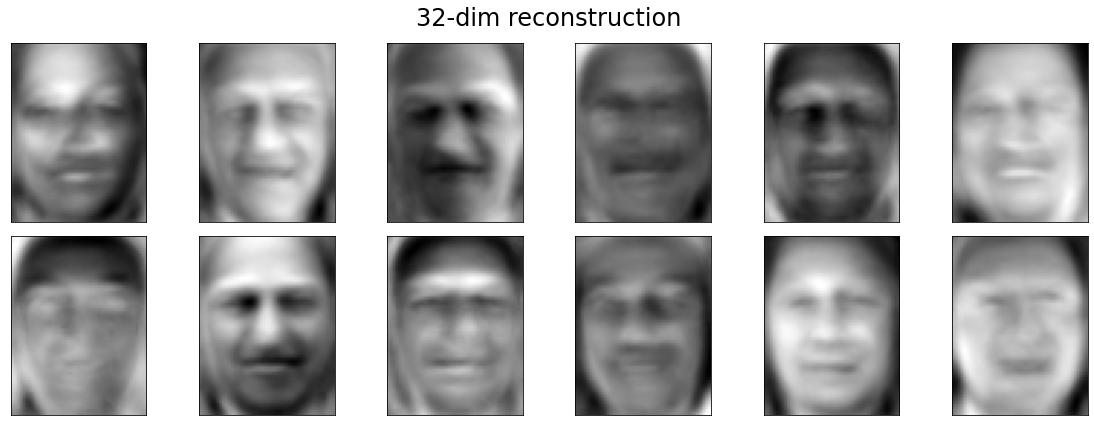

In [23]:
do_pca(32)

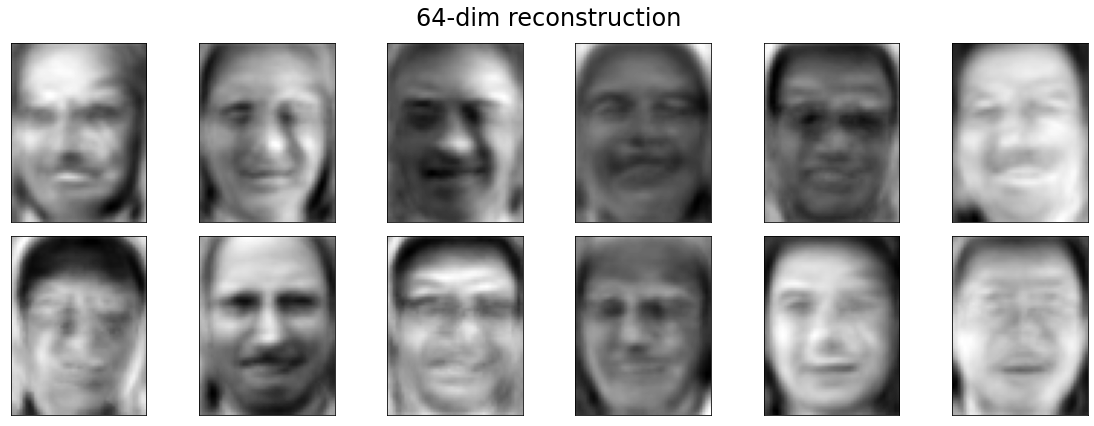

In [24]:
do_pca(64)

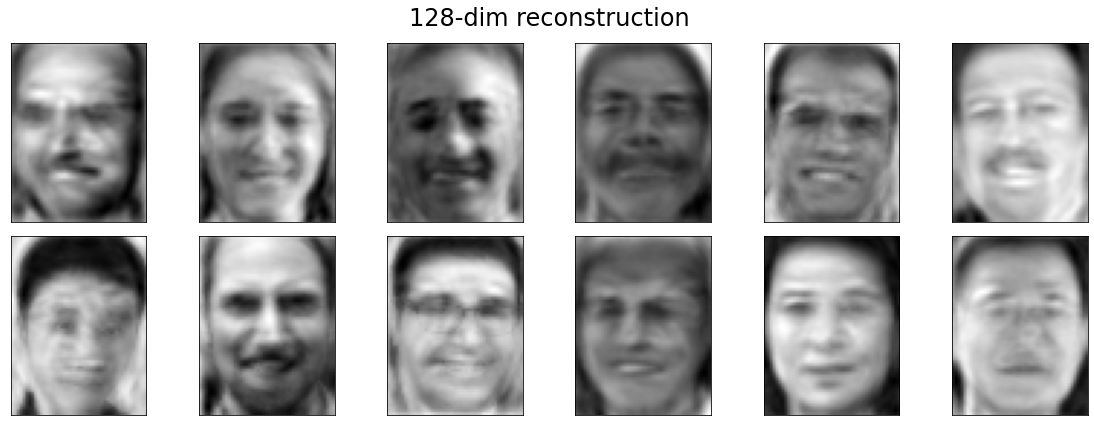

In [25]:
do_pca(128)

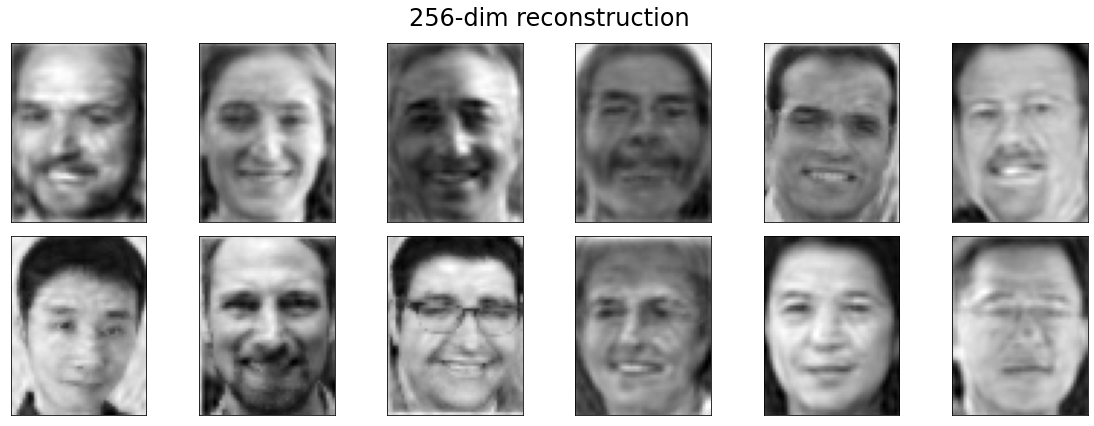

In [26]:
do_pca(256)

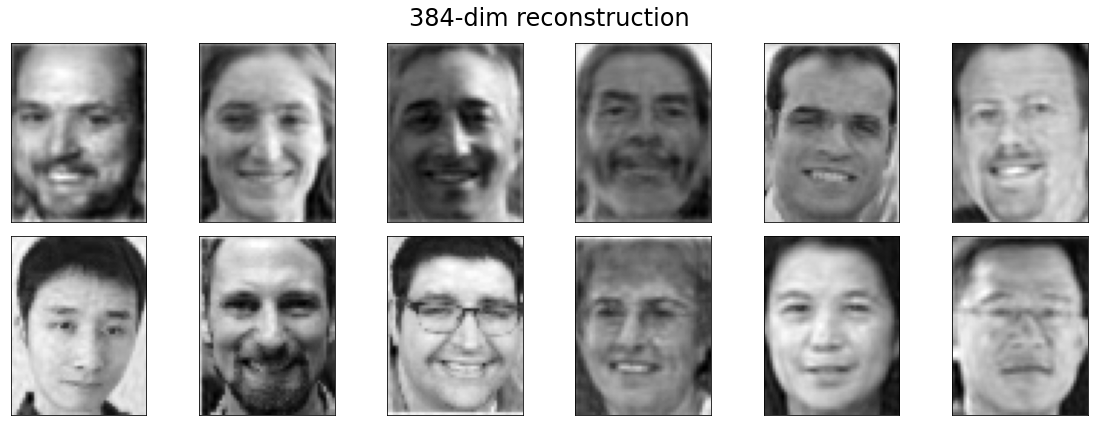

In [27]:
do_pca(384)

It's quite remarkable that our faces can well encapsulated in just a few hundred vectors.

---

## Exercise: PCA of hand-written digits
This is a classical machine learning dataset of hand-written digits in 8 by 8 grey pixels. 

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

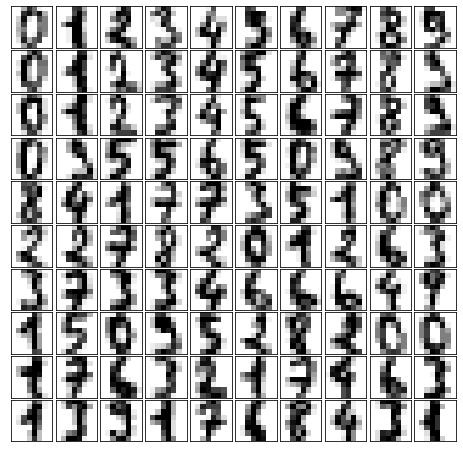

In [29]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

### Let's perform a PCA on these, report how many eigenvectors we need to capture 95\% of the variance 

### Show the most important 10 vectors in the 8 by 8 image space 

### Show the projections into the first two principal components, label each point by its digit (data.target). Which numbers are clustered together? In real life, which digits do you usually have trouble distinguishing? Is it the case here?